In [1]:
import os
import math
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from opencc import OpenCC

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from keras.layers.normalization import layer_normalization
from keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer, BertConfig, BertModel

In [2]:
bert_path = './chinese_roberta_wwm_ext_pytorch'
tokenizer = BertTokenizer(f'{bert_path}/vocab.txt')
config = BertConfig.from_pretrained(f'{bert_path}/bert_config.json')
embedding = BertModel.from_pretrained(f'{bert_path}/pytorch_model.bin', config=config)

ValueError: Can't find a vocabulary file at path './chinese_roberta_wwm_ext_pytorch/vocab.txt'. To load the vocabulary from a Google pretrained model use `tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)`

In [3]:
total_count = 317305

X = list()
Y = list()

cc = OpenCC('s2t')
data_path = './comment_data_v2'
type_names = ['attraction', 'bookstore', 'medical', 'restaurant', 'shopping']
progress = tqdm(total = total_count)
for type_label, type_name in enumerate(type_names):
    df = pd.read_excel(f'{data_path}/{type_name}.xlsx')
    for data in df.iloc:
        semantic_label = int(data['Star'] > 3)
        text = cc.convert(data['Comment'])
        X.append(tokenizer.encode(text))
        Y.append([semantic_label, type_label])
        progress.update(1)
X = pad_sequences(X, maxlen=100, padding='post', dtype='int')
X = torch.tensor(X)
Y = torch.tensor(Y)

torch.manual_seed(2)
shuffle_order = torch.randperm(X.shape[0])
X = X[shuffle_order]
Y = Y[shuffle_order]

  0%|          | 0/317305 [00:00<?, ?it/s]

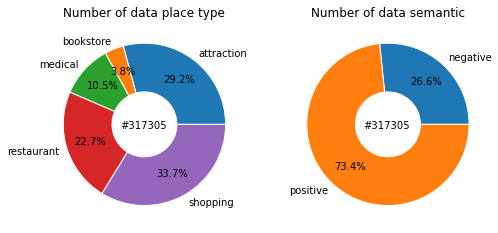

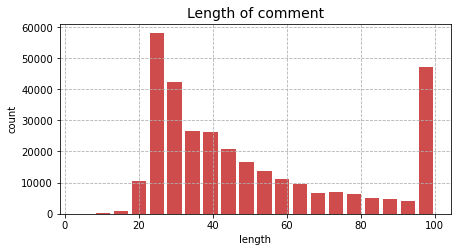

In [4]:
if Y.shape[1] == 2:
    Y = Y.transpose(1, 0)

size = [len(np.where(Y[1] == i)[0]) for i in range(5)]

fig, axes = plt.subplots(1, 2, figsize=(8, 8))

axs = axes[0]
axs.pie(size,
        labels = type_names,
        autopct = "%1.1f%%",
        pctdistance = 0.7,
        wedgeprops=dict(width=0.6, edgecolor='w'))
axs.text(-0.3, -0.05, f'#{total_count}')
axs.set_title("Number of data place type", fontsize=12) 

negative_count = len(np.where(Y[0] == 0)[0])
positive_count = len(np.where(Y[0] == 1)[0])

axs = axes[1]
axs.pie([negative_count, positive_count],
        labels=['negative', 'positive'], 
        autopct = "%1.1f%%",
        pctdistance = 0.7,
        wedgeprops=dict(width=0.6, edgecolor='w'))
axs.text(-0.3, -0.05, f'#{total_count}')
axs.set_title("Number of data semantic", fontsize=12) 

length = length = [len(np.nonzero(x)) for x in X]

plt.figure(figsize=(7, 3.5))
plt.grid(ls='--')
plt.hist(length, 
         bins=20,
         alpha=0.7,
         color='#BB0000',
         rwidth=0.8,
        )
plt.title("Length of comment", fontsize=14)
plt.xlabel('length')
plt.ylabel('count')

plt.show()

In [5]:
if Y.shape[0] == 2:
    Y = Y.transpose(1, 0)
    
train_X, val_X = X[:int(X.shape[0] * 0.8)], X[int(X.shape[0] * 0.8):]
train_Y, val_Y = Y[:int(Y.shape[0] * 0.8)], Y[int(Y.shape[0] * 0.8):]

batch_size = 128
train_dataset = TensorDataset(train_X, train_Y)
val_dataset = TensorDataset(val_X, val_Y)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False, num_workers=4)

class bert_model(nn.Module):
    def __init__(self, embedding):
        super(bert_model, self).__init__()
        self.embedding = embedding
        self.fc1 = nn.Linear(768, 2)
        self.fc2 = nn.Linear(768, 5)
    def forward(self, x):
        embedded = self.embedding(x)['pooler_output']
        out1 = self.fc1(embedded)
        out2 = self.fc2(embedded)
        return out1, out2

In [10]:
def get_log_string():
    log_string = '[{:02d}/{:02d}] {:2.2f} sec Train Acc1: {:3.2f}% Acc2: {:3.2f}% | Val Acc1: {:3.2f}% Acc2: {:3.2f}%]' \
                .format(epoch+1, num_epoch, time.time()-epoch_start_time, \
                train_acc1/train_count*100, train_acc2/train_count*100, \
                val_acc1/val_count*100, val_acc2/val_count*100)
    return log_string
    
os.makedirs('./log', exist_ok=True)
if os.path.exists('./log/log.txt'):
    os.remove('./log/log.txt')
    
model = bert_model(embedding).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss = nn.CrossEntropyLoss()

num_epoch = 5
progress = tqdm(total = len(train_loader) + len(val_loader), colour='purple', \
        bar_format='{desc}{percentage:3.0f}%|{bar}|{n}/{total}[{rate_fmt}{postfix}]')
best_acc1 = 0.0
best_acc2 = 0.0
for epoch in range(num_epoch):
    
    epoch_start_time = time.time()
    train_acc1 = 0.0
    train_acc2 = 0.0
    val_acc1 = 0.0
    val_acc2 = 0.0
    train_count = 1e-3
    val_count = 1e-3
    
    model.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        pred1, pred2 = model(data[0].cuda())
        loss1 = loss(pred1, data[1][:, 0].cuda())
        loss2 = loss(pred2, data[1][:, 1].cuda())
        batch_loss = loss1 + loss2
        batch_loss.backward()
        optimizer.step()
        
        train_acc1 += np.sum(np.argmax(pred1.cpu().data.numpy(), axis=1) == data[1][:, 0].numpy())
        train_acc2 += np.sum(np.argmax(pred2.cpu().data.numpy(), axis=1) == data[1][:, 1].numpy())
        train_count += batch_size
        
        progress.set_description(get_log_string())
        progress.update(1)
        
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            pred1, pred2 = model(data[0].cuda())
            
            val_acc1 += np.sum(np.argmax(pred1.cpu().data.numpy(), axis=1) == data[1][:, 0].numpy())
            val_acc2 += np.sum(np.argmax(pred2.cpu().data.numpy(), axis=1) == data[1][:, 1].numpy())
            val_count += batch_size
            
            progress.set_description(get_log_string())
            progress.update(1)
            
    if best_acc1 < val_acc1/val_count*100:
        best_acc1 = val_acc1/val_count*100
        torch.save(model.state_dict(), f'{bert_path}/best_model1.pth')
        
    if best_acc2 < val_acc2/val_count*100:
        best_acc2 = val_acc2/val_count*100
        torch.save(model.state_dict(), f'{bert_path}/best_model2.pth')
            
    progress.reset()
    print(get_log_string())
    with open('./log/log.txt', 'a') as train_record:
        train_record.write(get_log_string()+"\n")

  0%|          |0/2480[?it/s]

[01/05] 674.23 sec Train Acc1: 89.89% Acc2: 90.69% | Val Acc1: 89.16% Acc2: 90.02%]
[02/05] 673.84 sec Train Acc1: 90.83% Acc2: 92.08% | Val Acc1: 89.08% Acc2: 90.03%]
[03/05] 673.05 sec Train Acc1: 91.63% Acc2: 93.10% | Val Acc1: 89.09% Acc2: 89.87%]
[04/05] 673.10 sec Train Acc1: 92.47% Acc2: 93.95% | Val Acc1: 88.70% Acc2: 89.92%]
[05/05] 673.11 sec Train Acc1: 93.27% Acc2: 94.71% | Val Acc1: 88.82% Acc2: 89.79%]


In [ ]:
# model.load_state_dict(torch.load(f'{bert_path}/best_model1.pth'))

In [9]:
torch.cuda.empty_cache()